In [1]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [3]:
import os
import re
import numpy as np
import pandas as pd
import json
import scipy.stats as stats
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.externals import joblib

import tensorflow as tf
from tensorflow import keras
#import transformers as ppb
import torch

import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [7]:
#!git clone https://github.com/google-research/bert

Cloning into 'bert'...
remote: Enumerating objects: 336, done.
remote: Total 336 (delta 0), reused 0 (delta 0), pack-reused 336
Receiving objects: 100% (336/336), 297.11 KiB | 4.95 MiB/s, done.
Resolving deltas: 100% (183/183), done.


In [0]:
BERT_BASE_DIR="/content/drive/My Drive/MIDS/W266/bert_models/uncased_L-12_H-768_A-12"
DATA_DIR="/content/drive/My Drive/MIDS/W266/binary_tweet_dataset"
TRAINED_CLASSIFIER="/content/drive/My Drive/MIDS/W266/trained_models/bert_uncased"

In [5]:
os.chdir("/content/drive/My Drive/MIDS/W266/")
!ls

 bert				   dev_features.json
 bert_models			   test_features.json
 binary_tweet_dataset		   trained_models
 binary_tweets_bert_features.csv   train_features.json
 binary_tweets_valid.csv	  'W266 Project.ipynb'
'Copy of W266 Project.ipynb'


In [6]:
#load data
data =  pd.read_csv('binary_tweets_valid.csv', lineterminator='\n')
data.drop(columns=["index"], inplace=True)
data.head()

,tweet_id,user_id,id,tweet,url
0,339867818843594756,246979971,0,"@DoctorChristian scared to start fluoxetine, w...",http://twitter.com/246979971/status/3398678188...
1,349294537367236611,149749939,0,"@IntuitiveGal1 ok, if you stopped taking the L...",http://twitter.com/149749939/status/3492945373...
2,354256195432882177,54516759,0,Novartis announces secukinumab (AIN457) demons...,http://twitter.com/54516759/status/35425619543...
3,352456944537178112,1267743056,1,"""U wailed all night; now y'r disembodied sobbi...",http://twitter.com/1267743056/status/352456944...
4,332479707004170241,273421529,0,@irapaps you're so fucking selfish. I've got L...,http://twitter.com/273421529/status/3324797070...


In [0]:
#remove newline characters from tweets
def preprocess(s):
  s = re.sub(r'\n', ' ', s)
  return(s)
data['tweet'] = data['tweet'].apply(lambda x: preprocess(x))

In [0]:
split_data, test_data = train_test_split(data[['tweet','id']], test_size=0.2, random_state=0, stratify=data["id"])
train_data, dev_data = train_test_split(split_data, test_size=0.25, random_state=0, stratify=split_data["id"])

In [28]:
train_data.shape[0], dev_data.shape[0], test_data.shape[0]

(2501, 834, 834)

In [0]:
train_data.to_csv('./binary_tweet_dataset/train.tsv', sep='\t', index=False, header=False)
dev_data.to_csv('./binary_tweet_dataset/dev.tsv', sep='\t', index=False, header=False)
test_data.to_csv('./binary_tweet_dataset/test.tsv', sep='\t', index=False, header=False)

In [202]:
!python ./bert/run_classifier.py \
  --task_name=tweet \
  --do_train=true \
  --do_eval=true \
  --data_dir="$DATA_DIR" \
  --vocab_file="$BERT_BASE_DIR/vocab.txt" \
  --bert_config_file="$BERT_BASE_DIR/bert_config.json" \
  --init_checkpoint="$BERT_BASE_DIR/bert_model.ckpt" \
  --max_seq_length=128 \
  --train_batch_size=32 \
  --learning_rate=2e-5 \
  --num_train_epochs=3.0 \
  --output_dir="$TRAINED_CLASSIFIER"




W0308 08:50:39.371734 139928813586304 module_wrapper.py:139] From ./bert/run_classifier.py:821: The name tf.logging.set_verbosity is deprecated. Please use tf.compat.v1.logging.set_verbosity instead.


W0308 08:50:39.371930 139928813586304 module_wrapper.py:139] From ./bert/run_classifier.py:821: The name tf.logging.INFO is deprecated. Please use tf.compat.v1.logging.INFO instead.


W0308 08:50:39.372340 139928813586304 module_wrapper.py:139] From /content/drive/My Drive/MIDS/W266/bert/modeling.py:93: The name tf.gfile.GFile is deprecated. Please use tf.io.gfile.GFile instead.


W0308 08:50:39.373906 139928813586304 module_wrapper.py:139] From ./bert/run_classifier.py:846: The name tf.gfile.MakeDirs is deprecated. Please use tf.io.gfile.makedirs instead.

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addon

In [8]:
!python ./bert/extract_features.py \
  --input_file="$DATA_DIR/test.tsv" \
  --output_file="test_features.json" \
  --vocab_file="$BERT_BASE_DIR/vocab.txt" \
  --bert_config_file="$BERT_BASE_DIR/bert_config.json" \
  --init_checkpoint="$TRAINED_CLASSIFIER/model.ckpt-234" \
  --layers=-1,-2,-3,-4 \
  --max_seq_length=128 \
  --batch_size=8



W0308 19:51:07.703952 140317042583424 module_wrapper.py:139] From ./bert/extract_features.py:344: The name tf.logging.set_verbosity is deprecated. Please use tf.compat.v1.logging.set_verbosity instead.


W0308 19:51:07.704156 140317042583424 module_wrapper.py:139] From ./bert/extract_features.py:344: The name tf.logging.INFO is deprecated. Please use tf.compat.v1.logging.INFO instead.


W0308 19:51:07.704338 140317042583424 module_wrapper.py:139] From /content/drive/My Drive/MIDS/W266/bert/modeling.py:93: The name tf.gfile.GFile is deprecated. Please use tf.io.gfile.GFile instead.

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

W0308 19:51:07.806121 140317042583424 lazy_lo

In [0]:
def parse_embeddings(i, layer=0):
    """
    Parses json features output file from BERT model.
    
    Inputs
    i: index of the examples
    layer: 0 corresponds to the last layer(-1), 1 corresponds to second to last layer(-2), etc
    
    Outputs
    tokens: list of tokens of the example
    embeds: embeddings of all the tokens, dimensions are (number of tokens, embedding length)
    embeds_avg: average of the embeddings across all the tokens, dimension are (1, embedding length)
    """
    embed_json = pd.DataFrame(json.loads(lines[i]))
    num_tokens = embed_json.shape[0]
    tokens = [embed_json["features"][x]["token"] for x in range(num_tokens)]
    embeds = np.array([np.array(embed_json["features"][x]["layers"][layer]["values"]) for x in range(num_tokens)])
    embeds_avg = np.mean(embeds, axis=0)
    return(tokens, embeds, embeds_avg)

In [0]:
with open('train_features.json') as f:
  lines = f.readlines()

train_tokens = []
train_embeds = []
train_embeds_avg = []
for i in range(len(lines)):
    tokens, embeds, embeds_avg = parse_embeddings(i, 0)
    train_tokens.append(tokens)
    train_embeds.append(embeds)
    train_embeds_avg.append(embeds_avg)

In [0]:
with open('dev_features.json') as f:
  lines = f.readlines()

dev_tokens = []
dev_embeds = []
dev_embeds_avg = []
for i in range(len(lines)):
    tokens, embeds, embeds_avg = parse_embeddings(i, 0)
    dev_tokens.append(tokens)
    dev_embeds.append(embeds)
    dev_embeds_avg.append(embeds_avg)

In [0]:
with open('test_features.json') as f:
  lines = f.readlines()

test_tokens = []
test_embeds = []
test_embeds_avg = []
for i in range(len(lines)):
    tokens, embeds, embeds_avg = parse_embeddings(i, 0)
    test_tokens.append(tokens)
    test_embeds.append(embeds)
    test_embeds_avg.append(embeds_avg)

In [0]:
train_data = pd.read_csv("./binary_tweet_dataset/train.tsv", delimiter="\t", header=None, lineterminator='\n')
train_y = train_data[1]
train_x = train_embeds
train_x2 = train_embeds_avg

In [0]:
dev_data = pd.read_csv("./binary_tweet_dataset/dev.tsv", delimiter="\t", header=None, lineterminator='\n')
dev_y = dev_data[1]
dev_x = dev_embeds
dev_x2 = dev_embeds_avg

In [0]:
#combine train and dev sets
train_dev_y = np.append(train_data[1], dev_data[1])
train_dev_x2 = np.append(train_embeds_avg, dev_embeds_avg, axis=0)

In [71]:
len(train_dev_y)

3335

In [72]:
len(train_dev_x2)

3335

In [0]:
test_data = pd.read_csv("./binary_tweet_dataset/test.tsv", delimiter="\t", header=None, lineterminator='\n')
test_y = test_data[1]
test_x = test_embeds
test_x2 = test_embeds_avg

49.0

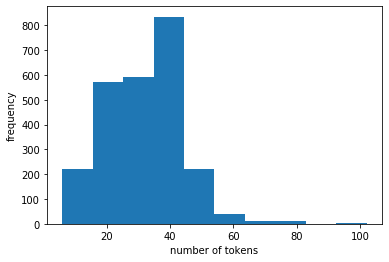

In [60]:
train_token_len = [len(x) for x in train_tokens]
plt.hist(train_token_len)
plt.xlabel("number of tokens")
plt.ylabel("frequency")
np.percentile(train_token_len, 95)

50.0

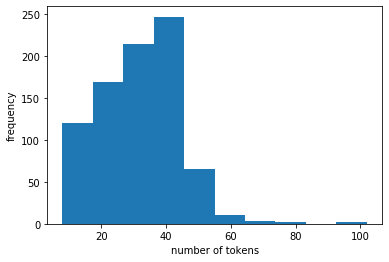

In [75]:
dev_token_len = [len(x) for x in dev_tokens]
plt.hist(dev_token_len)
plt.xlabel("number of tokens")
plt.ylabel("frequency")
np.percentile(dev_token_len, 95)

50.0

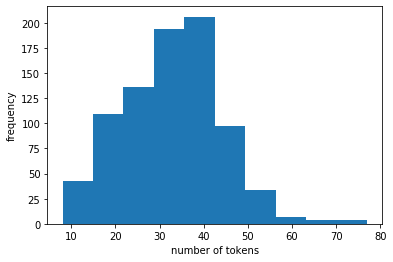

In [61]:
test_token_len = [len(x) for x in test_tokens]
plt.hist(test_token_len)
plt.xlabel("number of tokens")
plt.ylabel("frequency")
np.percentile(test_token_len, 95)

In [0]:
#LSTM (doesn't work yet, i think i need to pad it)
input_layer = tf.keras.layers.Input(shape=(768,50), name="input")
lstm_output = LSTM(100, input_shape=(768,50,))(input_layer)
classification_output = Dense(1, activation="sigmoid")(lstm_output)
lstm_model = Model(input_layer, classification_output)
lstm_model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])

lstm_model.reset_states()
lstm_model.fit(train_embeds, train_y, epochs=1)
lstm_model.summary()

In [86]:
#logistic regression
param_grid = {"C": np.linspace(0.0001, 100, 30),
              "penalty": ["l1", "l2", "elasticnet"],
              "class_weight": ["balanced", None]}
lr = LogisticRegression(random_state=0)
search = GridSearchCV(lr, param_grid, cv=3, scoring='f1')
search.fit(train_dev_x2, train_dev_y)
search.best_params_

{'C': 3.4483724137931033, 'class_weight': None, 'penalty': 'l2'}

In [87]:
train_pred = search.predict(train_dev_x2)
print(f"accuracy: {np.round(accuracy_score(train_pred, train_dev_y),4)*100}%")
print(f"f1-score: {np.round(f1_score(train_pred, train_dev_y),4)*100}%")

accuracy: 98.08%
f1-score: 91.42%


In [88]:
cm = confusion_matrix(train_pred, train_dev_y)
pd.DataFrame((cm/cm.sum())*100, columns=["pred neg","pred pos"], index=["true neg","true pos"]).round(2).astype(str).add('%')

,pred neg,pred pos
true neg,87.86%,0.84%
true pos,1.08%,10.22%


In [89]:
test_pred = search.predict(test_x2)
print(f"accuracy: {np.round(accuracy_score(test_pred, test_y),4)*100}%")
print(f"f1-score: {np.round(f1_score(test_pred, test_y),4)*100}%")

accuracy: 91.61%
f1-score: 61.11%


In [90]:
cm = confusion_matrix(test_pred, test_y)
pd.DataFrame((cm/cm.sum())*100, columns=["pred neg","pred pos"], index=["true neg","true pos"]).round(2).astype(str).add('%')

,pred neg,pred pos
true neg,85.01%,4.44%
true pos,3.96%,6.59%


In [0]:
deep_model = keras.Sequential([
                               keras.layers.Dense(5, input_shape=(768,), activation='relu'),
                               keras.layers.Dense(5, input_shape=(5,), activation='relu'),
                               keras.layers.Dense(1, activation='sigmoid')
])

deep_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

deep_model.fit(train_x2, train_y, epochs=50)

In [0]:
train_prob = deep_model.predict(train_x)
train_pred = np.where(train_prob >=0.5, 1, 0)
print(f"accuracy: {np.round(accuracy_score(train_pred, train_y),4)*100}%")
print(f"f1-score: {np.round(f1_score(train_pred, train_y),4)*100}%")

In [0]:
test_prob = deep_model.predict(test_x)
test_pred = np.where(test_prob >=0.5, 1, 0)
print(f"accuracy: {np.round(accuracy_score(test_pred, test_y),4)*100}%")
print(f"f1-score: {np.round(f1_score(test_pred, test_y),4)*100}%")